In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


In [60]:
depress_df = pd.read_csv("../datasets/Student Depression Dataset.csv")
depress_df.sample(5)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
22984,115917,Male,28.0,Kalyan,Student,4.0,0.0,8.63,4.0,0.0,5-6 hours,Unhealthy,B.Ed,No,4.0,4.0,Yes,1
6275,31435,Male,34.0,Vasai-Virar,Student,2.0,0.0,7.12,1.0,0.0,Less than 5 hours,Moderate,LLB,No,11.0,4.0,No,0
16140,81672,Male,34.0,Delhi,Student,4.0,0.0,7.09,4.0,0.0,Less than 5 hours,Unhealthy,M.Pharm,No,4.0,4.0,Yes,0
20801,105237,Female,21.0,Chennai,Entrepreneur,3.0,0.0,8.17,5.0,0.0,Less than 5 hours,Moderate,MCA,Yes,4.0,3.0,No,1
12310,62250,Male,23.0,Agra,Student,1.0,0.0,6.89,2.0,0.0,Less than 5 hours,Healthy,LLB,No,8.0,1.0,No,0


https://www.kaggle.com/datasets/hopesb/student-depression-dataset

In [61]:
depress_df["Financial Stress"] = depress_df["Financial Stress"].fillna(depress_df["Financial Stress"].mean())

In [62]:
depress_df['HigherDegree'] = depress_df['Degree'] != 'Class 12'
depress_df['HigherDegree'].replace({'True': 1, 'False': 0}, inplace=True)

C:\Users\ilchu\AppData\Local\Temp\ipykernel_18328\300208757.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  depress_df['HigherDegree'].replace({'True': 1, 'False': 0}, inplace=True)


In [63]:
depress_df['Sleep Duration'] = depress_df['Sleep Duration'].replace({'Others':depress_df['Sleep Duration'].mode()[0]})

In [64]:
num_cols = depress_df.select_dtypes(include=["number"]).columns
num_cols

Index(['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress', 'Depression'],
      dtype='object')

In [65]:
cat_cols = depress_df.select_dtypes('object').columns
cat_cols

Index(['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits',
       'Degree', 'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

In [66]:
cols_to_drop = ['id', 'City', 'Degree','Depression', 'Profession']
X = depress_df.drop(cols_to_drop, axis=1)  # Удаляем таргет
y = depress_df['Depression']

In [67]:
cat_cols = X.select_dtypes('object').columns
num_cols = X.select_dtypes(include=["number"]).columns

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols),
    ], remainder='passthrough')

In [69]:
X = preprocessor.fit_transform(X)

In [70]:
y

0        1
1        0
2        0
3        1
4        0
        ..
27896    0
27897    0
27898    0
27899    1
27900    1
Name: Depression, Length: 27901, dtype: int64

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ======================== ФУНКЦИЯ ОЦЕНКИ КАЧЕСТВА МОДЕЛИ ========================
# Эта функция вычисляет и выводит различные метрики качества классификации
# Включает оценку как на тренировочных, так и на тестовых данных

def evaluate(model, X_train, X_test, y_train, y_test):
    """
    Функция для комплексной оценки качества классификационной модели
    
    Параметры:
    - model: обученная модель классификации
    - X_train, y_train: тренировочные данные
    - X_test, y_test: тестовые данные
    
    Выводит:
    - Матрица ошибок (Confusion Matrix)
    - Точность (Accuracy Score)
    - Подробный отчет о классификации (Classification Report)
    """
    
    # Получаем предсказания модели на тренировочном наборе
    y_train_pred = model.predict(X_train)
    
    # Получаем предсказания модели на тестовом наборе
    y_test_pred = model.predict(X_test)

    # ========== ОЦЕНКА НА ТРЕНИРОВОЧНОМ НАБОРЕ ==========
    print("TRAINIG RESULTS: \n===============================")
    
    # Матрица ошибок: [истинные_отрицания  ложные_положительные]
    #                 [ложные_отрицания    истинные_положительные]
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    
    # Accuracy: доля правильно классифицированных образцов
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    
    # Classification Report включает:
    # - Precision (точность): TP / (TP + FP) - из предсказанных как позитив, сколько действительно позитив
    # - Recall (полнота): TP / (TP + FN) - из действительных позитивов, сколько предсказано
    # - F1-score: среднее гармоническое Precision и Recall
    # - Support: количество образцов класса
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    # ========== ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ ==========
    print("\nTESTING RESULTS: \n===============================")
    
    # Матрица ошибок на тестовом наборе
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    
    # Accuracy на тестовом наборе (главный критерий обобщаемости модели)
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    
    # Classification Report на тестовом наборе
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")


In [ ]:
# БАГГИНГ (Bagging - Bootstrap Aggregating)
# Баггинг - это ансамблевый метод, который:
# 1. Создает несколько подвыборок (bootstrap samples) из исходного набора данных
# 2. Обучает отдельный классификатор на каждой подвыборке
# 3. Объединяет предсказания всех классификаторов (усреднение)
# Это снижает дисперсию и предотвращает переобучение

# Создаем базовый классификатор (дерево решений)
tree = DecisionTreeClassifier()

# Создаем BaggingClassifier с параметрами:
# - estimator: базовый классификатор (дерево решений)
# - n_estimators: количество классификаторов в ансамбле (100)
# - random_state: фиксируем случайность для воспроизводимости
bagging_clf = BaggingClassifier(estimator=tree, n_estimators=100, random_state=42)

# Обучаем баггинг классификатор на тренировочных данных
bagging_clf.fit(X_train, y_train)


,estimator,DecisionTreeClassifier()
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [74]:
evaluate(bagging_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 9222     0]
 [    0 13098]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0        1  accuracy  macro avg  weighted avg
precision     1.0      1.0       1.0        1.0           1.0
recall        1.0      1.0       1.0        1.0           1.0
f1-score      1.0      1.0       1.0        1.0           1.0
support    9222.0  13098.0       1.0    22320.0       22320.0

TESTING RESULTS: 
CONFUSION MATRIX:
[[1804  539]
 [ 462 2776]]
ACCURACY SCORE:
0.8206
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.796117     0.837406  0.820641     0.816761      0.820072
recall        0.769953     0.857319  0.820641     0.813636      0.820641
f1-score      0.782816     0.847246  0.820641     0.815031      0.820197
support    2343.000000  3238.000000  0.820641  5581.000000   5581.000000


In [ ]:
# ======================== СРАВНЕНИЕ ТОЧНОСТИ БАГГИНГ МОДЕЛЕЙ ========================
# Создаем словарь для хранения результатов точности каждой модели
# Включаем результаты как для тренировочного, так и для тестового наборов

scores = {
    'Bagging Classifier': {
        # Accuracy на тренировочном наборе
        'Train': accuracy_score(y_train, bagging_clf.predict(X_train)),
        # Accuracy на тестовом наборе (более важен для оценки обобщаемости)
        'Test': accuracy_score(y_test, bagging_clf.predict(X_test)),
    },
}

In [ ]:
# EXTRA TREES (Extremely Randomized Trees) - вариант баггинга с рандомизацией
# Extra Trees - это улучшенная версия случайного леса (Random Forest):
# 1. Похож на Random Forest, но использует случайные пороги разделения для признаков
# 2. Это делает алгоритм быстрее, но может потребовать больше деревьев
# 3. Хорошо работает при наличии большого количества признаков

# Параметры:
# - n_estimators=100: количество деревьев в ансамбле
# - max_features=7: количество признаков, рассматриваемых при каждом разделении
# - random_state=42: фиксируем случайность
ex_tree_clf = ExtraTreesClassifier(n_estimators=100, max_features=7, random_state=42)

# Обучаем Extra Trees классификатор
ex_tree_clf.fit(X_train, y_train)


TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 9222     0]
 [    0 13098]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
                0        1  accuracy  macro avg  weighted avg
precision     1.0      1.0       1.0        1.0           1.0
recall        1.0      1.0       1.0        1.0           1.0
f1-score      1.0      1.0       1.0        1.0           1.0
support    9222.0  13098.0       1.0    22320.0       22320.0

TESTING RESULTS: 
CONFUSION MATRIX:
[[1802  541]
 [ 469 2769]]
ACCURACY SCORE:
0.8190
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.793483     0.836556  0.819029     0.815019      0.818473
recall        0.769099     0.855158  0.819029     0.812128      0.819029
f1-score      0.781101     0.845754  0.819029     0.813428      0.818612
support    2343.000000  3238.000000  0.819029  5581.000000   5581.000000


In [ ]:
evaluate(ex_tree_clf, X_train, X_test, y_train, y_test)

In [ ]:
# Добавляем результаты Extra Trees классификатора в словарь scores
scores['Extra Tree'] = {
        'Train': accuracy_score(y_train, ex_tree_clf.predict(X_train)),
        'Test': accuracy_score(y_test, ex_tree_clf.predict(X_test)),
    }
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.8206414621035657},
 'Extra Tree': {'Train': 1.0, 'Test': 0.8190288478767246}}

Boost

In [ ]:
# ADABOOST (Adaptive Boosting) - БУСТИНГ
# AdaBoost - это ансамблевый метод бустинга, который:
# 1. Последовательно обучает слабые классификаторы (обычно неглубокие деревья)
# 2. На каждом шаге увеличивает вес неправильно классифицированных образцов
# 3. Следующий классификатор сосредотачивается на ошибках предыдущих
# 4. Итоговое предсказание - это взвешенная сумма всех классификаторов
# Преимущество: адаптивно фокусируется на сложных образцах

# Параметры:
# - n_estimators=30: количество слабых классификаторов в ансамбле
ada_boost_clf = AdaBoostClassifier(n_estimators=30)

# Обучаем AdaBoost классификатор
ada_boost_clf.fit(X_train, y_train)


TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 7305  1917]
 [ 1478 11620]]
ACCURACY SCORE:
0.8479
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.831720      0.858388  0.847894      0.845054      0.847370
recall        0.792128      0.887158  0.847894      0.839643      0.847894
f1-score      0.811441      0.872536  0.847894      0.841989      0.847293
support    9222.000000  13098.000000  0.847894  22320.000000  22320.000000

TESTING RESULTS: 
CONFUSION MATRIX:
[[1838  505]
 [ 406 2832]]
ACCURACY SCORE:
0.8368
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.819073     0.848666  0.836768     0.833870      0.836243
recall        0.784464     0.874614  0.836768     0.829539      0.836768
f1-score      0.801395     0.861445  0.836768     0.831420      0.836235
support    2343.000000  3238.000000  0.836768  5581.000000   5581.000000


In [ ]:
evaluate(ada_boost_clf, X_train, X_test, y_train, y_test)

In [ ]:
# Добавляем результаты AdaBoost классификатора в словарь scores
scores['AdaBoost'] = {
        'Train': accuracy_score(y_train, ada_boost_clf.predict(X_train)),
        'Test': accuracy_score(y_test, ada_boost_clf.predict(X_test)),
    }
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.8206414621035657},
 'Extra Tree': {'Train': 1.0, 'Test': 0.8190288478767246},
 'AdaBoost': {'Train': 0.847894265232975, 'Test': 0.8367676043719764}}

In [ ]:
# GRADIENT BOOSTING - БУСТИНГ
# Gradient Boosting - это мощный ансамблевый метод, который:
# 1. Последовательно обучает деревья решений для минимизации функции потерь
# 2. Каждое новое дерево пытается исправить ошибки предыдущих деревьев
# 3. Использует градиент функции потерь для определения остатков
# 4. Обычно дает лучшие результаты, чем AdaBoost
# Преимущества: высокая точность, обработка нелинейных закономерностей

# Параметры:
# - n_estimators=100: количество последовательных деревьев
# - random_state=42: фиксируем случайность
grad_boost_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Обучаем Gradient Boosting классификатор
grad_boost_clf.fit(X_train, y_train)


TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 7378  1844]
 [ 1402 11696]]
ACCURACY SCORE:
0.8546
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.840319      0.863811   0.85457      0.852065      0.854105
recall        0.800043      0.892961   0.85457      0.846502      0.854570
f1-score      0.819687      0.878144   0.85457      0.848915      0.853991
support    9222.000000  13098.000000   0.85457  22320.000000  22320.000000

TESTING RESULTS: 
CONFUSION MATRIX:
[[1838  505]
 [ 399 2839]]
ACCURACY SCORE:
0.8380
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.821636     0.848983  0.838022     0.835310      0.837502
recall        0.784464     0.876776  0.838022     0.830620      0.838022
f1-score      0.802620     0.862656  0.838022     0.832638      0.837452
support    2343.000000  3238.000000  0.838022  5581.000000   5581.000000


In [ ]:
evaluate(grad_boost_clf, X_train, X_test, y_train, y_test)

In [ ]:
# Добавляем результаты Gradient Boosting классификатора в словарь scores
scores['Gradient Boosting'] = {
        'Train': accuracy_score(y_train, grad_boost_clf.predict(X_train)),
        'Test': accuracy_score(y_test, grad_boost_clf.predict(X_test)),
    }

# Выводим итоговые результаты всех четырех моделей
scores

{'Bagging Classifier': {'Train': 1.0, 'Test': 0.8206414621035657},
 'Extra Tree': {'Train': 1.0, 'Test': 0.8190288478767246},
 'AdaBoost': {'Train': 0.847894265232975, 'Test': 0.8367676043719764},
 'Gradient Boosting': {'Train': 0.8545698924731183,
  'Test': 0.8380218598817416}}

In [ ]:
# СРАВНЕНИЕ АНСАМБЛЕВЫХ МЕТОДОВ: ROC-АНАЛИЗ
# ROC (Receiver Operating Characteristic) кривая показывает компромисс между:
# - True Positive Rate (чувствительность): доля правильно классифицированных положительных примеров
# - False Positive Rate (1 - специфичность): доля ошибочно классифицированных отрицательных примеров
# AUC (Area Under Curve) - площадь под ROC-кривой (от 0 до 1)
# Чем выше AUC, тем лучше классификатор

# Создаем словарь с обученными классификаторами
classifiers = {
    'bagging_clf': bagging_clf,
    'Extra Tree': ex_tree_clf,
    'AdaBoost': ada_boost_clf,
    'Gradient Boosting': grad_boost_clf,
}

# Инициализируем словари для хранения метрик ROC для каждого классификатора
fpr = {}  # False Positive Rate 
tpr = {}  # True Positive Rate
roc_auc = {}  # Area Under Curve

# Вычисляем ROC кривые и AUC для каждого классификатора
for name, clf in classifiers.items():
    # Получаем вероятности классификации для класса 1 (положительный класс)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    # Вычисляем FPR, TPR и пороги для ROC кривой
    fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_proba)
    
    # Вычисляем AUC (площадь под кривой)
    roc_auc[name] = roc_auc_score(y_test, y_pred_proba)


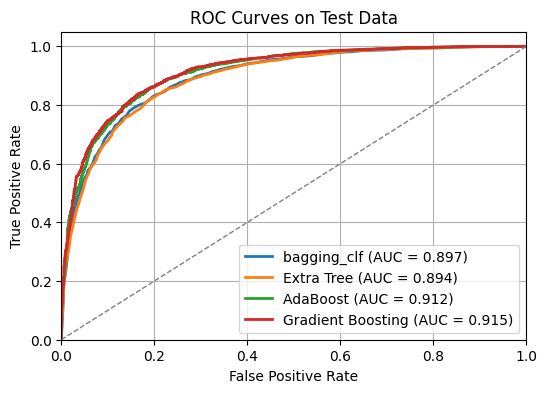

In [ ]:
# ВИЗУАЛИЗАЦИЯ ROC-КРИВЫХ для всех ансамблевых методов
# Создаем график ROC кривых для сравнения качества классификаторов
plt.figure(figsize=(6, 4))

# Строим ROC кривую для каждого классификатора
for name in classifiers:
    # lw=2: толщина линии
    # label: легенда с названием и значением AUC
    plt.plot(fpr[name], tpr[name], lw=2, label=f'{name} (AUC = {roc_auc[name]:.3f})')

# Строим диагональную линию (случайный классификатор, AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Устанавливаем диапазоны осей
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Подписи осей и название графика
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Test Data')

# Размещаем легенду в нижнем правом углу
plt.legend(loc='lower right')

# Добавляем сетку для удобства чтения
plt.grid(True)

# Выводим график
plt.show()


<Axes: >

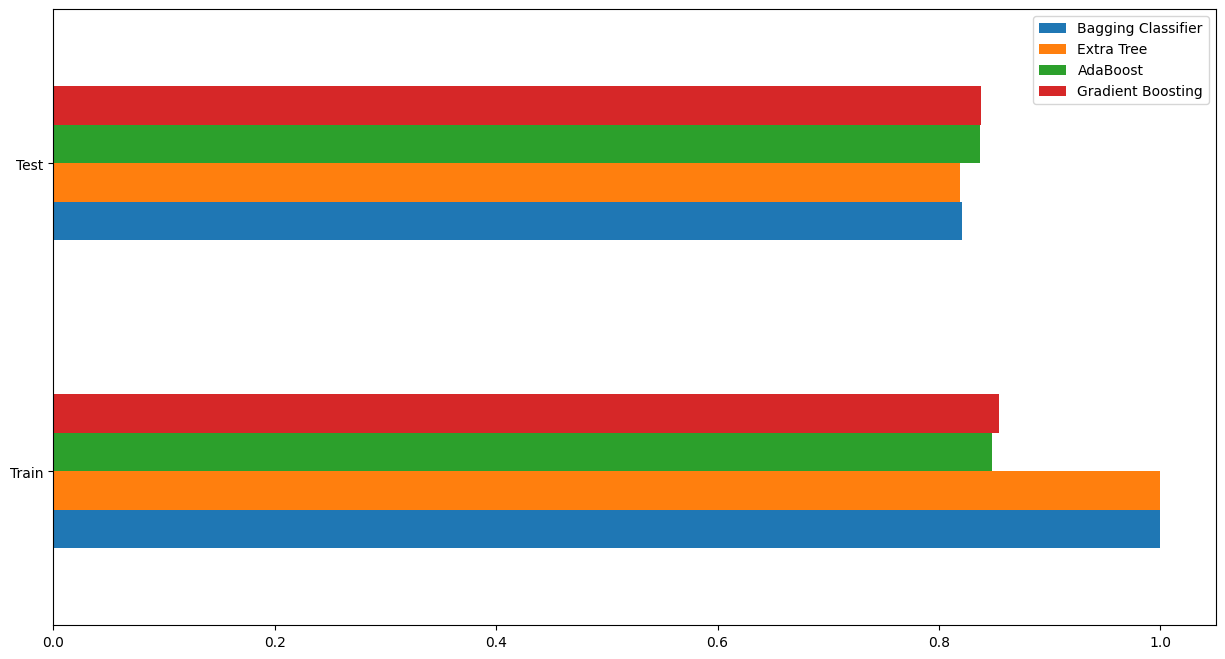

In [ ]:
# ======================== ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ ТОЧНОСТИ МОДЕЛЕЙ ========================
# Преобразуем словарь результатов в DataFrame для удобного отображения
scores_df = pd.DataFrame(scores)

# Создаем горизонтальную гистограмму для сравнения точности всех моделей
# kind='barh': горизонтальные столбцы
# figsize=(15, 8): размер графика
scores_df.plot(kind='barh', figsize=(15, 8))

# График показывает:
# - Каждая модель представлена строкой
# - Две полосы для каждой: Train (синяя) и Test (оранжевая)
# - Высота полосы соответствует значению точности
# - Это позволяет легко увидеть переобучение (большая разница между Train и Test)


Stacking

In [ ]:
# ======================== СТЕКИНГ (STACKING) ========================
# Стекинг - это метаалгоритм, который:
# 1. Обучает несколько разнородных базовых моделей (classifier 0-го уровня)
# 2. Использует предсказания базовых моделей как признаки для метамодели (classifier 1-го уровня)
# 3. Метамодель обучается объединять предсказания базовых моделей
# Преимущество: может использовать сильные стороны разных алгоритмов

# ========== ШАГ 1: ОПРЕДЕЛЕНИЕ БАЗОВЫХ МОДЕЛЕЙ (Classifier 0-го уровня) ==========
# Каждая базовая модель должна быть разных типов для разнообразия

# Decision Tree - дерево решений (хорошо ловит нелинейные закономерности)
tree = DecisionTreeClassifier(
    criterion='gini',           # Критерий качества разделения (gini или entropy)
    max_depth=2,                # Максимальная глубина дерева (ограничиваем)
    min_samples_split=10,       # Минимум образцов для разделения узла
    min_samples_leaf=5,         # Минимум образцов в листовом узле
    random_state=111,           # Фиксируем случайность
    class_weight="balanced"     # Учитываем дисбаланс классов
)

# Logistic Regression - логистическая регрессия (линейный классификатор)
logistic = LogisticRegression(
    penalty=None,               # Без регуляризации
    C=1.0,                      # Параметр регуляризации
    fit_intercept=True,         # Учитываем свободный коэффициент
    class_weight='balanced',    # Учитываем дисбаланс классов
    l1_ratio=None
)

# Linear SVM - линейная машина опорных векторов (максимизирует отступ)
lsvm = LinearSVC(
    penalty='l1',               # Тип штрафа (L1 - лассо)
    loss='squared_hinge',       # Функция потерь
    C=0.5,                      # Параметр регуляризации (обратный коэффициент)
    multi_class='ovr',          # One-vs-Rest для множественной классификации
    fit_intercept=True,
    class_weight='balanced',
    dual=False,
    random_state=111,
    max_iter=1000000            # Максимальное количество итераций
)

# Gaussian Naive Bayes - наивный Байесовский классификатор
nb = GaussianNB(priors=None)  # Предполагает нормальное распределение признаков

# ========== ШАГ 2: ОБУЧЕНИЕ БАЗОВЫХ МОДЕЛЕЙ ==========
# Обучаем каждую базовую модель на одинаковых тренировочных данных
tree.fit(X_train, y_train)
logistic.fit(X_train, y_train)
lsvm.fit(X_train, y_train)
nb.fit(X_train, y_train)

# ========== ШАГ 3: СОЗДАНИЕ И ОБУЧЕНИЕ СТЕКИНГ КЛАССИФИКАТОРА ==========
# StackingClassifier объединяет базовые модели и метамодель
stack_clf = StackingClassifier(
    # estimators: список кортежей (имя_модели, объект_модели)
    estimators=[
        ("tree", tree),
        ("logistic", logistic),
        ("lsvm", lsvm),
        ("nb", nb)
    ],
    # final_estimator: метамодель (2-го уровня), которая объединяет предсказания
    # На основе предсказаний базовых моделей метамодель делает финальное предсказание
    final_estimator=nb,
    # cv=5: кросс-валидация на 5 блоков при генерации признаков для метамодели
    cv=5,
    # stack_method='auto': автоматически выбирает метод (predict_proba или predict)
    stack_method='auto',
    # n_jobs=-1: использует все доступные ядра процессора
    n_jobs=-1,
    # passthrough=True: передает исходные признаки метамодели (помимо предсказаний)
    passthrough=True,
    verbose=0
)

# Обучаем стекинг классификатор
stack_clf.fit(X_train, y_train)

# ========== ШАГ 4: ПОДГОТОВКА КЛАССИФИКАТОРОВ ДЛЯ СРАВНЕНИЯ ==========
# Создаем словарь со всеми классификаторами для сравнения
classifiers = {
    "Decision Tree": tree,
    "Logistic Regression": logistic,
    "Linear SVM": lsvm,
    "Gaussian Naive Bayes": nb,
    "Stacked Classifier": stack_clf
}

# Инициализируем словари для хранения метрик ROC
fpr = {}
tpr = {}
roc_auc = {}

# ========== ШАГ 5: ВЫЧИСЛЕНИЕ ROC-КРИВЫХ ДЛЯ ВСЕХ КЛАССИФИКАТОРОВ ==========
# Вычисляем ROC кривые и AUC для каждого классификатора
for name, clf in classifiers.items():
    if name == "Linear SVM":
        # Linear SVM не имеет метода predict_proba, используем decision_function
        # decision_function возвращает расстояние от гиперплоскости разделения
        y_pred_scores = clf.decision_function(X_test)
        fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_scores)
        roc_auc[name] = roc_auc_score(y_test, y_pred_scores)
    elif name == "Stacked Classifier":
        # Для стекинг классификатора используем predict_proba
        y_pred_proba = stack_clf.predict_proba(X_test)[:, 1]
        fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_proba)
        roc_auc[name] = roc_auc_score(y_test, y_pred_proba)
    else:
        # Для остальных классификаторов используем predict_proba
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        fpr[name], tpr[name], _ = roc_curve(y_test, y_pred_proba)
        roc_auc[name] = roc_auc_score(y_test, y_pred_proba)


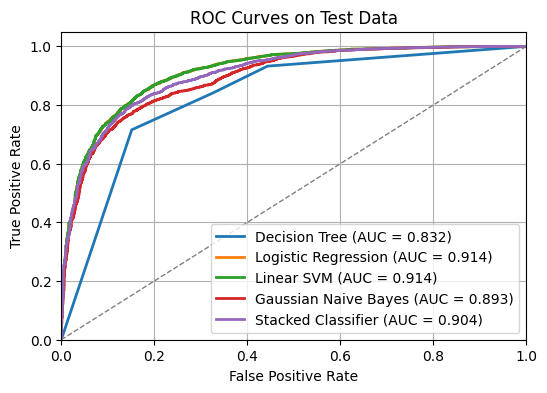

In [ ]:
# ======================== ВИЗУАЛИЗАЦИЯ ROC-КРИВЫХ ДЛЯ СТЕКИНГА ========================
# Этот график позволяет сравнить качество базовых моделей и стекинг классификатора

# Создаем новую фигуру для графика
plt.figure(figsize=(6, 4))

# Строим ROC кривую для каждого классификатора
for name in classifiers:
    # Построение линии с параметрами:
    # - fpr[name], tpr[name]: координаты для ROC кривой
    # - lw=2: толщина линии
    # - label: легенда с названием модели и значением AUC (площадь под кривой)
    plt.plot(fpr[name], tpr[name], lw=2, label=f'{name} (AUC = {roc_auc[name]:.3f})')

# Диагональная линия - это ROC кривая идеального случайного классификатора (AUC = 0.5)
# Любой хороший классификатор должен быть выше этой линии
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Устанавливаем диапазоны осей
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Подписи осей
plt.xlabel('False Positive Rate')    # Доля ложноположительных классификаций
plt.ylabel('True Positive Rate')     # Доля истинноположительных классификаций

# Название графика
plt.title('ROC Curves on Test Data')

# Размещаем легенду в нижнем правом углу (чтобы не перекрывала данные)
plt.legend(loc='lower right')

# Добавляем сетку для удобства чтения значений
plt.grid(True)

# Выводим график
plt.show()


In [ ]:
# ======================== ОЦЕНКА СТЕКИНГ КЛАССИФИКАТОРА ========================
# Вызываем функцию evaluate для комплексной оценки стекинг классификатора
# Получаем подробные метрики для тренировочного и тестового наборов
evaluate(stack_clf, X_train, X_test, y_train, y_test)


TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 7457  1765]
 [ 1923 11175]]
ACCURACY SCORE:
0.8348
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.794989      0.863601  0.834767      0.829295      0.835253
recall        0.808610      0.853184  0.834767      0.830897      0.834767
f1-score      0.801742      0.858361  0.834767      0.830051      0.834967
support    9222.000000  13098.000000  0.834767  22320.000000  22320.000000

TESTING RESULTS: 
CONFUSION MATRIX:
[[1873  470]
 [ 521 2717]]
ACCURACY SCORE:
0.8224
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.782373     0.852526  0.822433     0.817449      0.823074
recall        0.799402     0.839098  0.822433     0.819250      0.822433
f1-score      0.790796     0.845759  0.822433     0.818277      0.822684
support    2343.000000  3238.000000  0.822433  5581.000000   5581.000000


In [ ]:
evaluate(lsvm, X_train, X_test, y_train, y_test)


TRAINIG RESULTS: 
CONFUSION MATRIX:
[[ 7691  1531]
 [ 1875 11223]]
ACCURACY SCORE:
0.8474
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.803993      0.879959  0.847401      0.841976      0.848572
recall        0.833984      0.856848  0.847401      0.845416      0.847401
f1-score      0.818714      0.868250  0.847401      0.843482      0.847783
support    9222.000000  13098.000000  0.847401  22320.000000  22320.000000

TESTING RESULTS: 
CONFUSION MATRIX:
[[1940  403]
 [ 523 2715]]
ACCURACY SCORE:
0.8341
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.787657     0.870750   0.83408     0.829204      0.835867
recall        0.827998     0.838481   0.83408     0.833239      0.834080
f1-score      0.807324     0.854311   0.83408     0.830818      0.834585
support    2343.000000  3238.000000   0.83408  5581.000000   5581.000000
